In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
import flows

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import math

np.random.seed(1234)
tf.set_random_seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
!ls CDATA

AUS.csv  FRA.csv  GBR.csv


In [3]:
ccodes = ['FRA']#, 'FRA', 'GBR']
datas = ['./CDATA/{}.csv'.format(x) for x in ccodes]

In [4]:
datas[0]

'./CDATA/FRA.csv'

In [5]:
datas

['./CDATA/FRA.csv']

In [6]:
datas = [pd.read_csv(x, index_col='VARIABLE').values.astype(floatX).T[np.newaxis][:,1:-1]/100 for x in datas]

In [7]:
# datas = [x[:,:,:3] for x in datas]

In [8]:
[data.shape for data in datas]

[(1, 193, 4)]

In [9]:
# datas

In [10]:
scaler = 0.
for i, data in enumerate(datas):
    stds = (data[0,1:] - data[0,:-1]).std(axis=0)
    print(stds)
    scaler = scaler + stds
    datas[i] = data
print('---')
scaler /= len(datas)
for i in range(len(datas)):
    datas[i] /= scaler
    data = datas[i]
    stds = (data[0,1:] - data[0,:-1]).std(axis=0)
    print(stds)
    data = np.concatenate([data[:,1:], data[:,:-1]], axis=-1)
    datas[i] = data

[5.71697521e-05 9.31580167e-03 5.03056138e-05 3.01652631e-04]
---
[1. 1. 1. 1.]


In [11]:
datas[0][:,:4,:4]

array([[[ 3.59423921, -0.49378466,  2.09638097,  0.32795597],
        [ 5.51950517, -0.70131735,  4.25323269,  1.12706379],
        [ 4.22494461, -0.12523524,  3.02624164, -0.22863352],
        [ 5.93829855, -0.37928387,  3.92961811, -0.3696226 ]]])

In [12]:
country_data = {c:d for c,d in zip(ccodes, datas)}

In [15]:
class VARmodel:
    def __init__(self, data, name='VARmodel', mu=None):
        self.data = data
        self.NUM_STEPS = data.shape[1]
        self.name = name
        self.logdensities = []
        self.priors = []
        self.dim = [4,4*2+1]
        self.summaries = []
        
        self.stop_time = tf.placeholder_with_default(self.NUM_STEPS, ())
        self.observable_mask = tf.range(0, data.shape[1], dtype=tf.int32) < self.stop_time
        
        pd = np.mean(np.std(data[0,1:] - data[0,:-1], axis=0))
        
        with tf.variable_scope(name) as scope:
            self.scope = scope
            
            self.create_rw_priors()
            self.outputs = self.create_walk_inference(mu=mu)
            self.create_observ_dispersion_inference(pd*0.5)
            self.create_likelihood(self.observable_mask, self.outputs)
            self.summary = tf.summary.merge(self.summaries)
            
    def create_summary(self, stype, name, tensor):
        s = stype(name, tensor)
        self.summaries.append(s)

    def create_rw_priors(self):
        dim = self.dim
        with tf.variable_scope('rw_priors'):
            with tf.variable_scope('walk_ord'):
                s1_prior_d = LogNormal(1, mu=math.log(0.01/4), sigma=24., name='s1_prior')

                with tf.variable_scope('s1_inference', dtype=floatX):
                    mu = tf.get_variable('mu', shape=[1], 
                                         initializer=tf.constant_initializer(s1_prior_d.mu))

                    logsigma_init = tf.constant_initializer(min(math.log(s1_prior_d.sigma), -1.))
                    logsigma = tf.get_variable('logsigma', shape=[1], 
                                               initializer=logsigma_init)
                    sigma = tf.exp(logsigma)
                    s1_d = LogNormal(1, mu=mu, sigma=sigma)

                s1 = s1_d.sample()
                
                self.create_summary(tf.summary.scalar, 's1_ord', s1[0])
                
                self.logdensities.append(s1_d.logdens(s1))

                s1_prior = s1_prior_d.logdens(s1)
                self.priors.append(s1_prior)
                
            PWalk = NormalRW(dim=None, sigma0=.4, mu0=0., sigma=s1, name='OrdWalk')
            self.PWalk = PWalk
                
    def create_walk_inference(self, mu=None):
        dim = self.dim
        gvar = GVAR(dim=dim[0]*dim[1], len=self.NUM_STEPS, name='coef_rw_inference', mu=mu)
        outputs = gvar.sample()
        
        self.logdensities.append(gvar.logdens)
    
        self.priors.append(self.PWalk.logdens(outputs, reduce=True))
        self.outputs = outputs
        
        return outputs
    
    def create_observ_dispersion_inference(self, prior_disp):
        with tf.variable_scope('obs_d_inf', reuse=tf.AUTO_REUSE):
            ldiag = DFlow([LinearChol(dim=4, name='ldiag_flow_' + str(i)) for i in range(1)], init_sigma=0.05)

            ldiag.output -= 0.5*math.log(prior_disp)
            ldiag.logdens -= tf.reduce_sum(ldiag.output, axis=-1)
        
        self.obs_d = MVNormal(4, sigma=None, name='obs_d_posterior', 
                   ldiag=ldiag.output[0])
        
        df = 4
        pmat = np.diag([(2./prior_disp)]*4)/df
        cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)
        
        pr = cov_prior.log_prob(self.obs_d.fsigma)
        self.logdensities.append(ldiag.logdens[0])
        self.priors.append(pr)
        sigmas = tf.sqrt(tf.diag_part(self.obs_d.sigma))
        rsquareds = 1 - sigmas/np.std(self.data[0,1:,:4] - self.data[0,:-1,:4], axis=0)
        self.create_summary(tf.summary.scalar, 'rsquared_post_mean', tf.reduce_mean(rsquareds))
        self.create_summary(tf.summary.histogram, 'post_rsquared', rsquareds)
        self.create_summary(tf.summary.histogram, 'post_disp', tf.sqrt(tf.diag_part(self.obs_d.sigma)))
            
    def predict(self, observable_mask, outputs):
        dim = self.dim
        data = self.data
        out = tf.reshape(outputs, [self.NUM_STEPS, dim[0], dim[1]])

        def step(prev, x):
            mask = x[0]
            prev_pred = tf.where(mask, x[1], prev)[tf.newaxis]
            params = x[2]

            d0 = params[:,:dim[0]]
            d1 = params[:,dim[0]:2*dim[0]]

            pp1 = prev_pred[:,:dim[0]]
            pp0 = prev_pred[:,dim[0]:2*dim[0]]

            new_pred = tf.matmul(pp0, d0)[0] + tf.matmul(pp1, d1)[0]+ params[:,-1] + pp1[0]
            new_pred = tf.concat([new_pred, pp1[0]], axis=0)
            return new_pred

        ar = tf.scan(step, [observable_mask, data[0], out], initializer=tf.zeros([2*dim[0]], dtype=floatX))
        return ar
    
    def create_likelihood(self, observable_mask, outputs):
        dim = self.dim
        obs_d = self.obs_d#Normal(dim=None, sigma=self.obs_ds, mu=0) #self.obs_d
        
        preds = self.predict(observable_mask, outputs)
        
        diffs = preds[:-1] - data[0,1:]
        print(diffs)
        diffs = diffs[:,:dim[0]]
        
        rsq_obs = tf.sqrt(tf.reduce_mean(tf.square(diffs), axis=0))/np.std(self.data[0,1:,:4] - self.data[0,:-1,:4],
                                                                           axis=0)
        rsq_obs = 1-tf.reduce_mean(rsq_obs)
        self.create_summary(tf.summary.scalar, 'rsquared_observed', rsq_obs)

        logl = obs_d.logdens(diffs, reduce=False)
        print(logl)
        logl *= tf.cast(self.observable_mask[:-1], floatX)
        print(logl)

        logl = tf.reduce_sum(logl)
        self.create_summary(tf.summary.scalar, 'loglikelihood', logl)
        self.priors.append(logl)

In [13]:
from flows.models import VARmodel

In [14]:
d = datas[0][0]
d = pd.DataFrame(d.T, columns=range(d.shape[0]))
datas[0] = d

In [15]:
model = VARmodel(datas[0], name='FRA', var_dim=4, current_year=3000.)

ldiag logdens Tensor("FRA/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1, 1), dtype=float64)
Prior disp: [0.4960136  0.50113171 0.49799265 0.501307  ]
Tensor("FRA/moments/Squeeze_1:0", shape=(4,), dtype=float64) Tensor("FRA/DiagPart:0", shape=(4,), dtype=float64)


In [16]:
prior = tf.reduce_sum(model.priors)

logdensity = tf.reduce_sum(model.logdensities)

In [17]:
kl = logdensity - prior
kl /= 36*160

In [18]:
kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge([kls, tf.summary.scalar('prior', prior)] + [model.summaries])

In [19]:
main_op = tf.train.AdamOptimizer(0.0001).minimize(kl)

In [26]:
summary = tf.summary.merge_all()

In [20]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [21]:
init.run()

In [22]:
writer = tf.summary.FileWriter('/tmp/single_fra_model')

In [23]:
writer.add_graph(tf.get_default_graph())

In [24]:
epoch = 0

In [39]:
for epoch in range(epoch, 100000):
    for step in range(100):
        sess.run(main_op)
    s, _ = sess.run([summary, main_op])
    writer.add_summary(s, global_step=epoch)

KeyboardInterrupt: 

In [34]:
wsigmas = tf.sqrt(tf.diag_part(model.PWalk.sigma))

In [29]:
wsigmas

<tf.Tensor 'DiagPart:0' shape=(36,) dtype=float64>

In [ ]:
global_post=global_inf.output[0]

In [35]:
ss = []
for _ in range(1000):
    ss.append(wsigmas.eval())
ss = np.array(ss)

In [36]:
np.mean(ss,axis=0)

array([0.01057281, 0.01002172, 0.010137  , 0.01015096, 0.00996038,
       0.01008014, 0.01034078, 0.00984227, 0.01027494, 0.01040482,
       0.01059111, 0.0104048 , 0.01069173, 0.01068343, 0.01051031,
       0.01034837, 0.01061012, 0.01063628, 0.0100834 , 0.01050602,
       0.01046654, 0.01002109, 0.01000347, 0.01027779, 0.01067818,
       0.01050874, 0.01018217, 0.01063436, 0.01051371, 0.01017722,
       0.01052564, 0.01034194, 0.01029511, 0.01022439, 0.0106731 ,
       0.01055635])

In [37]:
ss.std(axis=0)

array([0.00053669, 0.00052003, 0.00050773, 0.00050136, 0.00053917,
       0.00053852, 0.000536  , 0.00049838, 0.00056192, 0.00052609,
       0.0005424 , 0.00050532, 0.00053951, 0.00052828, 0.00053357,
       0.00052908, 0.00054998, 0.00054073, 0.00049659, 0.00055683,
       0.00052255, 0.00051622, 0.00051754, 0.00054203, 0.00056497,
       0.00053385, 0.00055636, 0.00057259, 0.00055209, 0.00051383,
       0.00052952, 0.00051975, 0.00052797, 0.000518  , 0.00054586,
       0.0005505 ])

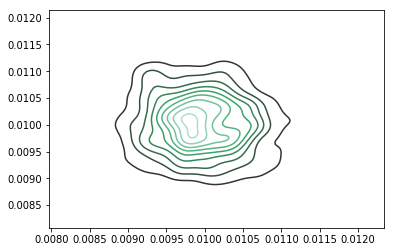

In [38]:
sns.kdeplot(ss[:,4], ss[:,1])
plt.show()